In [104]:
import pandas as pd
import yaml
import wandb
import matplotlib.pyplot as plt
import numpy as np

from transformers import T5Tokenizer, T5ForConditionalGeneration


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import itertools

In [2]:
# Loading Credentials
with open("credentials.yaml", 'r') as stream:
    credentials = yaml.safe_load(stream)

In [3]:
wandbApiKey = credentials['wandb']['key']

In [4]:
train_df = pd.read_csv('singletask_noupsampling_train.csv')
val_df = pd.read_csv('singlatask_noupsampling_val.csv')
unlabeled_df = pd.read_csv('unlabelled_df.csv')

In [142]:
train_df_upsampled = pd.read_csv('singletask_train.csv')

In [97]:
# Initializing windb session:
wandb.init(project="transfer-learning-using-a-transformer-model-lp", entity="roivian")

In [98]:
label_map = list(train_df['target_text'].unique())
print(label_map)

['Templates', 'Question', 'Review', 'Stylus problems']


## 2. Train model on raw data

In [7]:
train_df['target_label'] = train_df['target_text'].apply(label_map.index)
val_df['target_label'] = val_df['target_text'].apply(label_map.index)

In [8]:
train_df.head(5)

,input_text,target_text,target_label
0,HEX set of bright highlighters — enjoy! (HEX c...,Templates,0
1,How do I fix this? You may need to update Goo...,Question,1
2,My Colorful Covers Feel free to download and ...,Templates,0
3,How can I avoid excessive margins when importi...,Question,1
4,"Artists’ support, I created an art journal on ...",Review,2


In [9]:
val_df.head(5)

,input_text,target_text,target_label
0,"Drag Scrollbar on iPadOS 13 In iPadOS 13, Appl...",Question,1
1,"Weird lag recently, is it the app or my device...",Question,1
2,How do I move or remove an element? I've used ...,Question,1
3,"By popular demand, made a few free element pac...",Templates,0
4,Question about iCloud backups Does goodnotes b...,Question,1


#### Now the actual training

In [13]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [24]:
# Optional model configuration
# model_args = ClassificationArgs(
#     num_train_epochs=5, wandb_project="transfer-learning-using-a-transformer-model-lp", 
#     save_eval_checkpoints= True, wandb_kwargs= {"name": "DB1_raw"},
#     evaluate_during_training= True, evaluate_during_training_verbose= True, overwrite_output_dir=True)

model_args = ClassificationArgs(
    num_train_epochs=5, wandb_project="transfer-learning-using-a-transformer-model-lp", 
    wandb_kwargs= {"name": "DB1_raw_t1"}, overwrite_output_dir=True)

# Create a ClassificationModel
model = ClassificationModel(
    #'bert',
    #'bert-base-cased',
    "distilbert",
    "distilbert-base-uncased",
    num_labels=len(label_map),
    args=model_args,
    use_cuda=False
) 

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

In [25]:
# Train the model
model.train_model(train_df[['input_text','target_label']])#,eval_df=val_df[['input_text','target_label']]

  0%|          | 0/192 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/24 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/24 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/24 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/24 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/24 [00:00<?, ?it/s]

(120, 0.6255255173891783)

In [26]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(val_df[['input_text','target_label']])

/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/simpletransformers/classification/classification_model.py:1426: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/49 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss,█▁
global_step,▁█
lr,█▁
Training loss,0.18042
global_step,100
lr,1e-05


#### Evaluation

In [88]:
# Evaluating On Validation DataSet:
val_y_true = list(val_df['target_label'])
val_y_pred = model.predict(list(val_df['input_text']))[0]

  0%|          | 0/49 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/7 [00:00<?, ?it/s]

In [99]:
# Measuring Performance

print(classification_report(val_y_true, val_y_pred))

              precision    recall  f1-score   support

           0       0.56      0.83      0.67         6
           1       0.90      0.92      0.91        39
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         2

    accuracy                           0.84        49
   macro avg       0.36      0.44      0.39        49
weighted avg       0.78      0.84      0.81        49



/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [134]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [135]:

cm = confusion_matrix(val_y_true, val_y_pred)

Confusion matrix, without normalization


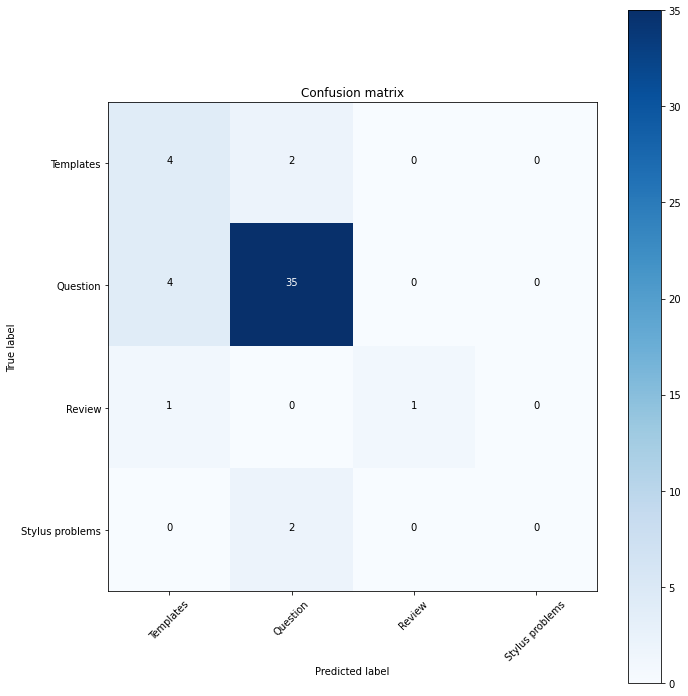

In [136]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=label_map);

## 2. Train model on Upsampled Data

In [107]:
train_df_upsampled['target_label'] = train_df_upsampled['target_text'].apply(label_map.index)

In [108]:
train_df_upsampled.head(5)

,input_text,target_text,target_label
0,Battery drain i’ve been using my ipadpro for n...,Question,1
1,GoodNotes on iCloud I can not find my GoodNote...,Question,1
2,Flash card shuffle? Is there a way to shuffle ...,Question,1
3,First Attempt With GoodNotes! Any thought? Ni...,Review,2
4,Which backup is the best for good notes - Drop...,Question,1


In [124]:
# Optional model configuration
# model_args = ClassificationArgs(
#     num_train_epochs=5, wandb_project="transfer-learning-using-a-transformer-model-lp", 
#     save_eval_checkpoints= True, wandb_kwargs= {"name": "DB1_raw"},
#     evaluate_during_training= True, evaluate_during_training_verbose= True, overwrite_output_dir=True)

up_model_args = ClassificationArgs(
    num_train_epochs=10, wandb_project="transfer-learning-using-a-transformer-model-lp", 
    wandb_kwargs= {"name": "DB2_up"}, overwrite_output_dir=True)

# Create a ClassificationModel
up_model = ClassificationModel(
    #'bert',
    #'bert-base-cased',
    "distilbert",
    "distilbert-base-uncased",
    num_labels=len(label_map),
    args=up_model_args,
    use_cuda=False
) 

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

In [125]:
# Train the model
up_model.train_model(train_df_upsampled[['input_text','target_label']])#,eval_df=val_df[['input_text','target_label']]

/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/simpletransformers/classification/classification_model.py:585: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/312 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/39 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/39 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/39 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/39 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/39 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/39 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/39 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/39 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/39 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/39 [00:00<?, ?it/s]

(390, 0.209473023406612)

In [126]:
# Evaluate the model
result, model_outputs, wrong_predictions = up_model.eval_model(val_df[['input_text','target_label']])

/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/simpletransformers/classification/classification_model.py:1426: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/49 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss,█▂▁▁▁▁▁
global_step,▁▂▃▅▆▇█
lr,█▇▆▅▃▂▁
Training loss,0.00238
global_step,350
lr,0.0


#### Evaluate the Upsampled Model

In [127]:
# Evaluating On Validation DataSet:
val_y_true = list(val_df['target_label'])
val_y_pred_up = up_model.predict(list(val_df['input_text']))[0]

  0%|          | 0/49 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/7 [00:00<?, ?it/s]

In [128]:
# Measuring Performance (Raw)
print("Raw Data")
print(classification_report(val_y_true, val_y_pred))

Raw Data
              precision    recall  f1-score   support

           0       0.44      0.67      0.53         6
           1       0.90      0.90      0.90        39
           2       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         2

    accuracy                           0.82        49
   macro avg       0.59      0.52      0.52        49
weighted avg       0.81      0.82      0.81        49



/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [129]:
# Measuring Performance
print("Upsampled Data")
print(classification_report(val_y_true, val_y_pred_up))

Upsampled Data
              precision    recall  f1-score   support

           0       0.44      0.67      0.53         6
           1       0.87      0.87      0.87        39
           2       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         2

    accuracy                           0.80        49
   macro avg       0.58      0.51      0.52        49
weighted avg       0.79      0.80      0.79        49



/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [131]:

cm = confusion_matrix(val_y_true, val_y_pred_up)

Confusion matrix, without normalization


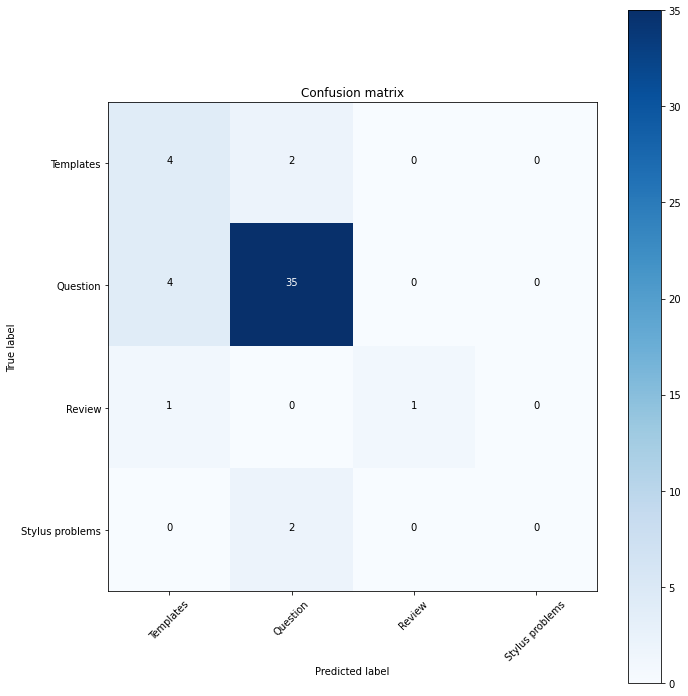

In [137]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=label_map);

In [141]:
# Clerly F1Score is the most appropriate metric for Class Imbalanced Problem
# However for some reason model that I built on upsampled dataset performed the same as the one build on raw dataset
# Model on 10 epochs is clearly overfitted, but I was not sure what oferfitting techniques I could use for Transformer models 